In [58]:
from netCDF4 import Dataset
from glob import glob
import numpy as np

from wrf import getvar, ALL_TIMES, extract_times

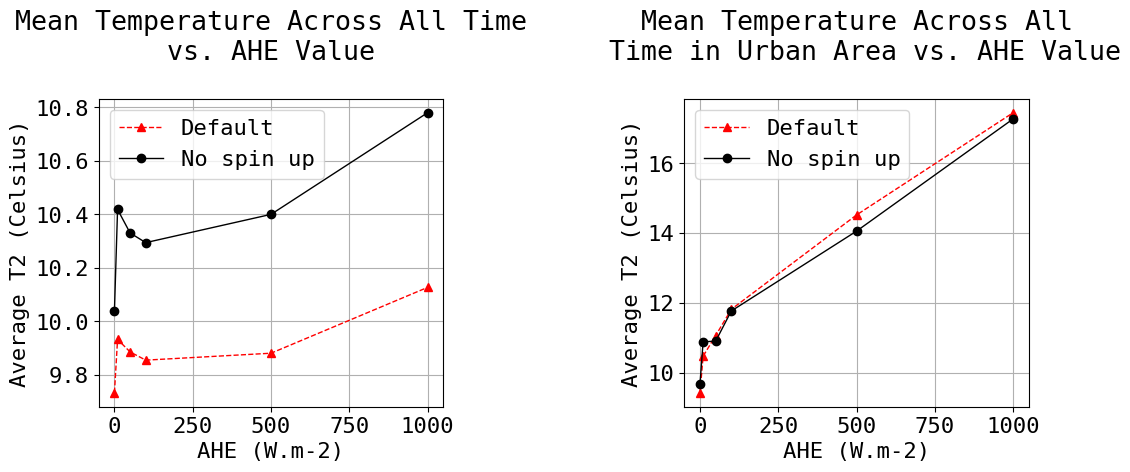

In [63]:
import matplotlib.pyplot as plt

AHE_VALUES = [0, 10, 50, 100, 500, 1000]
# AHE_VALUES = [50, 100, 200]
Z0_VALUES = [0.5, 1, 2, 5, 10]
all_mean_values, all_mean_values_urb = [], []
cut_mean_values, cut_mean_values_urb = [], []

plt.rcParams['font.size'] = 16
_, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.7)

# iterate_values = Z0_VALUES
iterate_values = AHE_VALUES
threshold_datetime = np.datetime64('2025-03-10')

for ahe in AHE_VALUES:
    z0 = 1
# for z0 in Z0_VALUES:
#     ahe = 100
    file_name = glob(f'/home/guc/runs/*-ahe-{ahe}-z0-{z0}/wrfout*.backup')[0]
    # file_name = glob(f'/home/guc/runs/*-ahe-{ahe}-rnd-wind/wrfout*')[0]
    dataset = Dataset(file_name)

    all_times = extract_times(dataset, timeidx=ALL_TIMES)

    all_t2_values = getvar(dataset, "T2", timeidx=ALL_TIMES)
    cut_t2_value = []
    for time_idx, date_time in enumerate(all_times):
        if (date_time < threshold_datetime): continue
        cut_t2_value.append(all_t2_values[time_idx])

    cut_t2_value = np.array(cut_t2_value)
    cut_t2_mean = np.mean(cut_t2_value)
    cut_t2_mean_urb = np.mean(cut_t2_value[:, 40:60, 40:60])

    cut_mean_values.append(cut_t2_mean - 273.15)
    cut_mean_values_urb.append(cut_t2_mean_urb - 273.15)

    all_mean_values.append(np.mean(all_t2_values) - 273.15)
    all_mean_values_urb.append(np.mean(all_t2_values[:, 40:60, 40:60]) - 273.15)


axes[0].set_title('Mean Temperature Across All Time\nvs. AHE Value', y=1.1)
axes[0].plot(iterate_values, all_mean_values, '^--', linewidth=1, color="red", label="Default")
axes[0].plot(iterate_values, cut_mean_values, 'o-', linewidth=1, color="black", label="No spin up")

axes[1].set_title('Mean Temperature Across All\n Time in Urban Area vs. AHE Value', y=1.1)
axes[1].plot(iterate_values, all_mean_values_urb, '^--', linewidth=1, color="red", label="Default")
axes[1].plot(iterate_values, cut_mean_values_urb, 'o-', linewidth=1, color="black", label="No spin up")

for i in range(2):
    axes[i].set_xlabel('AHE (W.m-2)')
    # axes[i].set_xlabel('Z0 (m)')
    axes[i].set_ylabel('Average T2 (Celsius)')
    axes[i].legend()
    axes[i].grid()

plt.savefig('/home/guc/results/z0-1-ahe-mean-temp.svg')

In [ ]:
import matplotlib.dates as mdates

times = [] 
fig, axes = plt.subplots(2, 2, figsize=(12, 11))

# for ahe in AHE_VALUES:
#     z0 = 1
for z0 in Z0_VALUES:
    ahe = 100
    file_name = glob(f'/home/guc/runs/*-ahe-{ahe}-z0-{z0}/wrfout*.backup')[0]
    dataset = Dataset(file_name)

    if len(times) == 0:
        times = extract_times(dataset, timeidx=ALL_TIMES)
    t2_values = getvar(dataset, "T2", timeidx=ALL_TIMES)
    mean_t2_values = np.mean(t2_values, axis=(1, 2)) - 273.15
    mean_t2_values_urban = np.mean(t2_values[:, 40:60, 40:60], axis=(1, 2)) - 273.15

    axes[0][0].plot(times, mean_t2_values, label=f"AHE={ahe}")
    axes[0][1].plot(times, mean_t2_values_urban, label=f"AHE={ahe}")

    axes[1][0].plot(times, np.max(t2_values, axis=(1, 2)) - 273.15, label=f"AHE={ahe}")
    axes[1][1].plot(times, np.max(t2_values[:, 40:60, 40:60], axis=(1, 2)) - 273.15, label=f"AHE={ahe}")


for i in range(2):
    for j in range(2):
        axes[i][j].legend()
        axes[i][j].grid()
        axes[i][j].set_xlabel('Time')
        axes[i][j].xaxis.set_major_formatter(mdates.DateFormatter('%b %d-%H:%M'))
        axes[i][j].set_xticks(times[::len(times)//4])
        axes[i][j].set_ylabel('Temperature (Celsius)')
        axes[i][j].set_xlim(times[0], times[-1])

axes[0][0].set_title('Time Series of Mean Temperature vs. AHE Value')
axes[0][1].set_title('Time Series of Mean Temperature in Urban Area vs. AHE Value')

axes[1][0].set_title('Time Series of Max Temperature vs. AHE Value')
axes[1][1].set_title('Time Series of Max Temperature in Urban Area vs. AHE Value')

# plt.savefig('/home/guc/results/z0-1-ahe-temp-time-series.png')

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * np.sqrt(x) + b

avg_urb_vals = [9.422052, 10.46807251, 11.05895386, 11.81130371, 14.51546631, 17.44454346]